In [1]:
# from google.colab import drive
# drive.flush_and_unmount()           # ignore errors if already unmounted

#If cannot remount, simply delete the mounted drive and then remount
# rm -rf /content/drive


In [2]:
# Colab cell
from google.colab import drive

drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [3]:
# Adjust these two for YOUR repo
REPO_OWNER = "kadkins3880"
REPO_NAME  = "STAT4160"   # e.g., unified-stocks-team1
BASE_DIR   = "/content/drive/MyDrive/dspt25"
CLONE_DIR  = f"{BASE_DIR}/{REPO_NAME}"
REPO_URL   = f"https://github.com/{REPO_OWNER}/{REPO_NAME}.git"

# if on my office computer

# REPO_NAME  = "lectureNotes"   # e.g., on my office computer
# BASE_DIR = r"E:\OneDrive - Auburn University Montgomery\teaching\AUM\STAT 4160 Productivity Tools" # on my office computer
# CLONE_DIR  = f"{BASE_DIR}\{REPO_NAME}"

import os, pathlib
pathlib.Path(BASE_DIR).mkdir(parents=True, exist_ok=True)


In [4]:
import os, subprocess, shutil, pathlib

if not pathlib.Path(CLONE_DIR).exists():
    !git clone {REPO_URL} {CLONE_DIR}
else:
    # If the folder exists, just ensure it's a git repo and pull latest
    os.chdir(CLONE_DIR)
    # !git status
    # !git pull --rebase # !git pull --ff-only
os.chdir(CLONE_DIR)
print("Working dir:", os.getcwd())

Working dir: /content/drive/MyDrive/dspt25/STAT4160


## Session 18 — Walk‑forward + Regime Analysis

### Learning goals

By the end of class, students can:

1.  Use **embargoed** rolling‑origin splits (Session 15) and apply a **static universe** (Session 17) consistently.
2.  Construct **volatility regimes** (low/med/high) from **rolling volatility** computed **causally** (≤ t), and set regime thresholds **using training‑only** data per split.
3.  Evaluate **MAE, sMAPE, MASE** **by regime**, with macro and micro aggregation.
4.  Make **calibration plots** (binned predicted vs. realized returns) **by regime** and interpret them.

------------------------------------------------------------------------

## Agenda

-   walk‑forward recap (expanding vs sliding), embargo; regime intuition
-   defining regimes (rolling std), training‑only thresholds, leakage pitfalls
-   **In‑class lab**: add regime labels (train‑only quantiles) → evaluate naive & linear‑lags **by regime** → calibration plots
-   Wrap‑up + homework brief

------------------------------------------------------------------------

### Why regime analysis?

-   Model error is **not uniform**. Many models fail during **high‑volatility** periods.
-   Reporting **one global metric** hides when/where models break.
-   Regime‑aware metrics guide **feature/model design** and **risk controls**.

### Splits & embargo refresher

-   **Rolling‑origin, expanding**: train grows, validation moves forward.
-   **Embargo**: gap (e.g., 5 business days) between train end and val start to reduce adjacency leakage.

### Defining volatility regimes (avoid leakage)

-   Use **rolling standard deviation** of returns (e.g., `roll_std_20`) computed **up to and including t**.
-   **Thresholds**: choose quantiles (e.g., 33% and 66%) **on TRAIN ONLY** for each split; label both train & val using those fixed thresholds.
-   **Categories**: `low`, `med`, `high`. Treat labels as **categorical dtypes**.

### Metrics & calibration by regime

-   Compute **MAE, sMAPE, MASE** **within each regime**. Aggregate macro/micro.

-   **Calibration (point forecasts)**: bin predictions into deciles; plot **mean predicted vs. mean realized** per bin.

    -   Perfect calibration ⇒ points on the 45° line.
    -   Plot one figure **overall** and one **per regime**.

------------------------------------------------------------------------

## In‑class lab (Colab‑friendly)

> Run each block as its **own cell**. Adjust `REPO_NAME` to your repo name.

### 0) Setup & load (with safe fallbacks)


In [5]:
import os, pathlib, numpy as np, pandas as pd, json
from pathlib import Path

for p in ["data/raw","data/processed","data/static","reports","scripts","tests","docs/figs"]:
    Path(p).mkdir(parents=True, exist_ok=True)
print("Working dir:", os.getcwd())

# Load returns; synthesize if missing
rpath = Path("data/processed/returns.parquet")
if rpath.exists():
    returns = pd.read_parquet(rpath)
else:
    rng = np.random.default_rng(0)
    dates = pd.bdate_range("2022-01-03", periods=360)
    frames=[]
    for t in ["AAPL","MSFT","GOOGL","AMZN","NVDA"]:
        eps = rng.normal(0,0.012,size=len(dates)).astype("float32")
        adj = 100*np.exp(np.cumsum(eps))
        df = pd.DataFrame({
            "date": dates, "ticker": t,
            "adj_close": adj.astype("float32"),
            "log_return": np.r_[np.nan, np.diff(np.log(adj))].astype("float32")
        })
        df["r_1d"] = df["log_return"].shift(-1)
        df["weekday"] = df["date"].dt.weekday.astype("int8")
        df["month"]   = df["date"].dt.month.astype("int8")
        frames.append(df)
    returns = pd.concat(frames, ignore_index=True).dropna().reset_index(drop=True)
    returns["ticker"] = returns["ticker"].astype("category")
    returns.to_parquet(rpath, index=False)

# Load features or generate minimal set with rolling std (causal)
fpath = Path("data/processed/features_v1.parquet")
if fpath.exists():
    feats = pd.read_parquet(fpath)
    if "roll_std_20" not in feats.columns:
        # ensure we have rolling volatility
        feats = feats.sort_values(["ticker","date"])
        feats["roll_std_20"] = feats.groupby("ticker")["log_return"].rolling(20, min_periods=20).std().reset_index(level=0, drop=True)
else:
    feats = returns.sort_values(["ticker","date"]).copy()
    for k in [1,2,3]:
        feats[f"lag{k}"] = feats.groupby("ticker")["log_return"].shift(k)
    feats["roll_std_20"] = feats.groupby("ticker")["log_return"].rolling(20, min_periods=20).std().reset_index(level=0, drop=True)

# If static universe exists from Session 17, apply it
univ_files = sorted(Path("data/static").glob("universe_*.csv"))
if univ_files:
    univ = pd.read_csv(univ_files[-1])["ticker"].astype(str)
    feats = feats[feats["ticker"].astype(str).isin(set(univ))]
    returns = returns[returns["ticker"].astype(str).isin(set(univ))]

# Harmonize types & sort
for df in (returns, feats):
    df["date"] = pd.to_datetime(df["date"])
    df["ticker"] = df["ticker"].astype("category")
feats = feats.dropna(subset=["log_return"]).sort_values(["ticker","date"]).reset_index(drop=True)
returns = returns.sort_values(["ticker","date"]).reset_index(drop=True)
feats.head(3)

Working dir: /content/drive/MyDrive/dspt25/STAT4160


,date,ticker,log_return,r_1d,weekday,month,lag1,lag2,lag3,roll_mean_20,roll_std_20,zscore_20,ewm_mean_20,ewm_std_20,exp_mean,exp_std,adj_close,volume
0,2020-01-29,AAPL,-0.018417,-0.002351,2,1,-0.012895,-0.019012,-0.004576,-0.004086,0.008476,-1.690830,-0.005252,0.009304,-0.004086,0.008476,92.154846,1598707
1,2020-01-30,AAPL,-0.002351,-0.012675,3,1,-0.018417,-0.012895,-0.019012,-0.004353,0.008324,0.240455,-0.004976,0.008875,-0.004003,0.008270,91.938454,2992900
2,2020-01-31,AAPL,-0.012675,0.002713,4,1,-0.002351,-0.018417,-0.012895,-0.004849,0.008517,-0.918756,-0.005709,0.008745,-0.004397,0.008280,90.780533,634335


### 1) Rolling‑origin splits (expanding) with embargo

In [6]:
import numpy as np, pandas as pd

def make_rolling_origin_splits(dates, train_min=252, val_size=63, step=63, embargo=5):
    u = np.array(sorted(pd.to_datetime(pd.Series(dates).unique())))
    splits=[]; i=train_min-1; n=len(u)
    while True:
        if i>=n: break
        a,b = u[0], u[i]
        vs = i + embargo + 1
        ve = vs + val_size - 1
        if ve>=n: break
        splits.append((a,b,u[vs],u[ve]))
        i += step # next training window size =current window sz +step
    return splits

splits = make_rolling_origin_splits(feats["date"], train_min=80, val_size=21, step=21, embargo=5)
print("Num splits:", len(splits))
splits[:2]

Num splits: 3


[(Timestamp('2020-01-29 00:00:00'),
  Timestamp('2020-05-19 00:00:00'),
  Timestamp('2020-05-27 00:00:00'),
  Timestamp('2020-06-24 00:00:00')),
 (Timestamp('2020-01-29 00:00:00'),
  Timestamp('2020-06-17 00:00:00'),
  Timestamp('2020-06-25 00:00:00'),
  Timestamp('2020-07-23 00:00:00'))]

### 2) Regime thresholds from **training‑only** (quantiles of rolling vol)

In [7]:
def regime_thresholds(train_df, vol_col="roll_std_20", q_low=0.33, q_high=0.66):
    v = train_df[vol_col].dropna().to_numpy()
    if len(v) < 100:  # defensive: small train
        q_low, q_high = 0.4, 0.8
    return float(np.quantile(v, q_low)), float(np.quantile(v, q_high)) # return quantile, see below for more details

def label_regime(df, vol_col, lo, hi):
    # low: <= lo, high: >= hi, else med; NaNs -> 'unknown'
    out = df.copy()
    vc = out[vol_col]
    regime = pd.Series(pd.Categorical(["unknown"]*len(out), categories=["low","med","high","unknown"]), index=out.index) # see below for creating Categorical data
    regime[(vc.notna()) & (vc <= lo)] = "low"  # see below for .notna()
    regime[(vc.notna()) & (vc > lo) & (vc < hi)] = "med"
    regime[(vc.notna()) & (vc >= hi)] = "high"
    out["regime"] = regime.astype("category")
    return out

# Demonstrate on first split in class
a,b,c,d = splits[0]
tr = feats[(feats["date"]>=a) & (feats["date"]<=b)]
va = feats[(feats["date"]>=c) & (feats["date"]<=d)]
lo, hi = regime_thresholds(tr, "roll_std_20", 0.33, 0.66)
tr_lab = label_regime(tr, "roll_std_20", lo, hi)
va_lab = label_regime(va, "roll_std_20", lo, hi)
print({"lo": lo, "hi": hi}, tr_lab["regime"].value_counts().to_dict(), va_lab["regime"].value_counts().to_dict())

{'lo': 0.008945737965404987, 'hi': 0.010225054807960987} {'high': 680, 'low': 660, 'med': 660, 'unknown': 0} {'med': 207, 'high': 177, 'low': 141, 'unknown': 0}


```python
np.quantile(v, q_high)
```

`np.quantile` is a **NumPy** function that returns the **q-th quantile** (percentile) of the input data.

For example:

* `q_high = 0.5` → the **median**
* `q_high = 0.9` → the **90th percentile**
* `q_high = 0.25` → the **first quartile**

It computes a cutoff value `x` such that **q_high fraction** of the elements in `v` are **≤ x**.

Formally:
$$
\text{np.quantile}(v, q) = \text{the value } x \text{ where } P(V \le x) = q
$$

---

### Example

```python
import numpy as np
v = np.array([10, 20, 30, 40, 50])
np.quantile(v, 0.9)
```

Output:

```
46.0
```

That means 90% of the data are ≤ 46.

---

###  Multiple quantiles

You can also pass several quantiles:

```python
np.quantile(v, [0.25, 0.5, 0.75])
```

Output:

```
array([20., 30., 40.])
```

---

### Optional parameters

* `axis` → compute quantiles along a particular axis (for 2D arrays)
* `keepdims` → keep the reduced dimension
* `method` (since NumPy 1.22) → interpolation method, e.g. `'linear'`, `'midpoint'`

---




Let’s explain **why 46**, and then the meaning of **`keepdims`** and **`method`**.

---

## Step 1: Understand how quantiles are computed

Quantiles are **fractional positions** in a *sorted* array.

Sorted `v` = `[10, 20, 30, 40, 50]`
Number of elements = `n = 5`

The **q-th quantile** is at *fractional index*:
$$
i = q \times (n - 1)
$$

For `q = 0.9`:
$$
i = 0.9 \times (5 - 1) = 0.9 \times 4 = 3.6
$$

So, the 90th percentile lies **between the 4th and 5th elements** (0-based indexing → positions 3 and 4).

---

## Step 2: Interpolation

Element at index 3 = 40
Element at index 4 = 50

Fractional part = 0.6

NumPy uses **linear interpolation** by default:
$$
\text{result} = 40 + 0.6 \times (50 - 40) = 40 + 6 = 46.0
$$

Hence, **46** is the interpolated 90th percentile.

---

##  Step 3: `method` argument

`method` controls *how to interpolate* between points or how to interpret the definition of “quantile.”
It replaced the older `interpolation` argument since NumPy 1.22.

Common values:

| Method                 | Description                                | Example outcome for `q=0.9`    |
| ---------------------- | ------------------------------------------ | ------------------------------ |
| `'linear'` *(default)* | Linear interpolation between nearest ranks | 46.0                           |
| `'lower'`              | Always choose the lower data point         | 40                             |
| `'higher'`             | Always choose the higher data point        | 50                             |
| `'midpoint'`           | Average of the two                         | 45                             |
| `'nearest'`            | Closest actual data point                  | 40 or 50 depending on rounding |

So if you ran:

```python
np.quantile(v, 0.9, method='midpoint')
```

you’d get `45.0`.

---

##  Step 4: `keepdims` argument

`keepdims` only matters for **multi-dimensional arrays**.

* When `keepdims=False` (default), NumPy *reduces* the dimension you take the quantile over.
* When `keepdims=True`, it keeps that axis as a dimension of size 1.

Example:

```python
a = np.array([[1, 2], [3, 4]])
np.quantile(a, 0.5, axis=0)
```

→ Output: `[2., 3.]` (shape `(2,)`)

```python
np.quantile(a, 0.5, axis=0, keepdims=True)
```

→ Output: `[[2., 3.]]` (shape `(1, 2)`)

That’s useful if you later want to **broadcast** the quantiles back onto the original array.



## Createa a labeled categorical Series

```python
regime = pd.Series(
    pd.Categorical(
        ["unknown"] * len(out),
        categories=["low", "med", "high", "unknown"]
    ),
    index=out.index
)
```

This is a compact way to **create a labeled categorical Series** in pandas, with a **fixed set of categories** and the same index as another DataFrame (`out`).


### 1. `["unknown"] * len(out)`

This builds a list of `"unknown"` repeated once for every row in `out`.

Example:
If `len(out) == 5`, this gives:

```python
["unknown", "unknown", "unknown", "unknown", "unknown"]
```

---

### 2. `pd.Categorical([...], categories=["low","med","high","unknown"])`

Creates a **categorical array** — a pandas data type for values that take on a limited, fixed number of possible values (called *categories*).

* The values are initially `"unknown"`.
* The allowed categories are explicitly declared as `["low", "med", "high", "unknown"]`.

This ensures the Series can later hold only one of these four values — not arbitrary strings.

So you can later safely do:

```python
regime[out["feature"] < 0.3] = "low"
regime[out["feature"] > 0.7] = "high"
```

without introducing new unintended categories.



### 4. The result

You get a **pandas Series** that looks like:

```
2020-01-01    unknown
2020-01-02    unknown
2020-01-03    unknown
...
dtype: category
Categories (4, object): ['low', 'med', 'high', 'unknown']
```



### `.notna()`
```
vc = [0.1, np.nan, 0.3]
vc.notna() → [True, False, True]
```


### 3) Baseline predictions (naive & linear‑lags per ticker, fit on TRAIN only)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# features we will use for linear baseline
XCOLS = [c for c in ["lag1","lag2","lag3"] if c in feats.columns]
if not XCOLS:
    # create lags on the fly (causal)
    feats = feats.sort_values(["ticker","date"]).copy()
    for k in [1,2,3]:
        feats[f"lag{k}"] = feats.groupby("ticker")["log_return"].shift(k)
    XCOLS = ["lag1","lag2","lag3"]

def fit_predict_lin_per_ticker(train_df, val_df):
    preds=[]
    for tkr, trk in train_df.groupby("ticker"):
        vak = val_df[val_df["ticker"]==tkr]
        if len(trk)==0 or len(vak)==0: continue
        pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
        pipe.fit(trk[XCOLS].dropna().values, trk.dropna(subset=XCOLS)["r_1d"].values)
        yhat = pipe.predict(vak[XCOLS].fillna(0).values)
        out = vak[["date","ticker","r_1d","log_return","regime"]].copy()
        out["yhat_lin"] = yhat.astype("float32")
        preds.append(out)
    return pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

def add_naive_preds(df):
    out = df.copy()
    out["yhat_naive"] = out["log_return"]  # r_{t+1} ~ log_return_t
    return out

tr_lab2 = add_naive_preds(tr_lab)
va_lab2 = add_naive_preds(va_lab)
val_lin = fit_predict_lin_per_ticker(tr_lab2, va_lab2)
val = va_lab2.merge(val_lin[["date","ticker","yhat_lin"]], on=["date","ticker"], how="left")
val.head(3)

/tmp/ipython-input-2694456256.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tkr, trk in train_df.groupby("ticker"):


,date,ticker,log_return,r_1d,weekday,month,lag1,lag2,lag3,roll_mean_20,...,zscore_20,ewm_mean_20,ewm_std_20,exp_mean,exp_std,adj_close,volume,regime,yhat_naive,yhat_lin
0,2020-05-27,AAPL,-0.006239,0.002054,2,5,-0.008317,0.022448,0.001641,-0.000810,...,-0.533310,-0.001739,0.010827,-0.001671,0.008972,83.908554,230841,med,-0.006239,0.001949
1,2020-05-28,AAPL,0.002054,0.004930,3,5,-0.006239,-0.008317,0.022448,-0.000702,...,0.270186,-0.001378,0.010361,-0.001636,0.008937,84.081085,2510027,med,0.002054,-0.001519
2,2020-05-29,AAPL,0.004930,-0.001764,4,5,0.002054,-0.006239,-0.008317,-0.000233,...,0.504552,-0.000777,0.010037,-0.001574,0.008917,84.496635,3288956,high,0.004930,-0.001978


### 4) Metrics **by regime** (MAE, sMAPE, MASE; macro & micro)

In [9]:
import warnings
warnings.filterwarnings('ignore')


In [10]:
def mae(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def smape(y,yhat,eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(2.0*np.abs(y-yhat)/(np.abs(y)+np.abs(yhat)+eps)))

def mase(y_true, y_pred, y_train_true, y_train_naive):
    scale = mae(y_train_true, y_train_naive) + 1e-12
    return float(mae(y_true,y_pred)/scale)

def per_regime_metrics(val_df, train_df, pred_col):
    rows = []

    # Pre-group training by ticker once (faster)
    train_by_ticker = {
        tkr: g.dropna(subset=["r_1d"])
        for tkr, g in train_df.groupby("ticker")
    }

    for reg, g in val_df.groupby("regime"):
        if reg == "unknown" or len(g) == 0:
            continue

        per_t = []
        for tkr, gv in g.groupby("ticker"):
            gt = train_by_ticker.get(tkr)
            if gt is None or gt.empty:
                continue

            # Align & drop NaNs in y / yhat
            y = gv["r_1d"]
            yhat = gv[pred_col]
            mask = y.notna() & yhat.notna()
            if not mask.any():
                continue

            y = y[mask]
            yhat = yhat[mask]

            # If mase needs clean scaling inputs, align/drop there too
            m = {
                "ticker": tkr,
                "n": int(mask.sum()),
                "mae": float(mae(y, yhat)),
                "smape": float(smape(y, yhat)),
                "mase": float(mase(y, yhat, gt["r_1d"], gt["log_return"])),
                "regime": reg,
            }
            per_t.append(m) # per_t is a list of dict of the same structure

        per_t = pd.DataFrame(per_t) # convert a list of dict into a dataframe
        if per_t.empty:
            continue

        macro = per_t[["mae", "smape", "mase"]].mean().to_dict()

        w = per_t["n"].to_numpy()
        wsum = w.sum()
        if wsum == 0:
            # fall back to macro if no weights
            micro = {
                "micro_mae": float(per_t["mae"].mean()),
                "micro_smape": float(per_t["smape"].mean()),
                "micro_mase": float(per_t["mase"].mean()),
            }
        else:
            micro = {
                "micro_mae": float(np.average(per_t["mae"], weights=w)),
                "micro_smape": float(np.average(per_t["smape"], weights=w)),
                "micro_mase": float(np.average(per_t["mase"], weights=w)),
            }

        rows.append({ # build a new dict by adding new fields.
            "regime": reg,
            **{f"macro_{k}": float(v) for k, v in macro.items()},
            **micro # unpacking an existing dict into key-value pairs inline
        })

    return pd.DataFrame(rows)


met_naive = per_regime_metrics(val, tr_lab2, "yhat_naive")
met_lin   = per_regime_metrics(val.dropna(subset=["yhat_lin"]), tr_lab2, "yhat_lin")
print("NAIVE by regime:\n", met_naive)
print("\nLIN-LAGS by regime:\n", met_lin)
# Save
pd.concat([
    met_naive.assign(model="naive"),
    met_lin.assign(model="lin_lags")
], ignore_index=True).to_csv("reports/regime_metrics_split1.csv", index=False)

NAIVE by regime:
   regime  macro_mae  macro_smape  macro_mase  micro_mae  micro_smape  \
0    low   0.010896     1.401762    1.023209   0.009961     1.470442   
1    med   0.012401     1.575014    1.149930   0.011820     1.547136   
2   high   0.011426     1.464757    1.055282   0.011656     1.417321   

   micro_mase  
0    0.948458  
1    1.110862  
2    1.066599  

LIN-LAGS by regime:
   regime  macro_mae  macro_smape  macro_mase  micro_mae  micro_smape  \
0    low   0.010333     1.726408    0.969139   0.008131     1.629521   
1    med   0.008137     1.664620    0.757888   0.007879     1.680100   
2   high   0.007027     1.490651    0.638798   0.007865     1.568236   

   micro_mase  
0    0.771618  
1    0.741442  
2    0.711831  


### 5) **Calibration plots** overall and by regime (binned)

'Saved docs/figs/calibration_by_regime_lin.png'

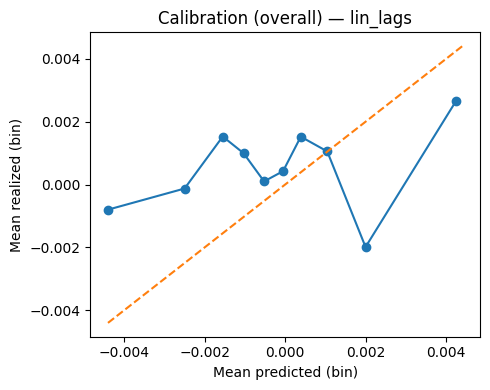

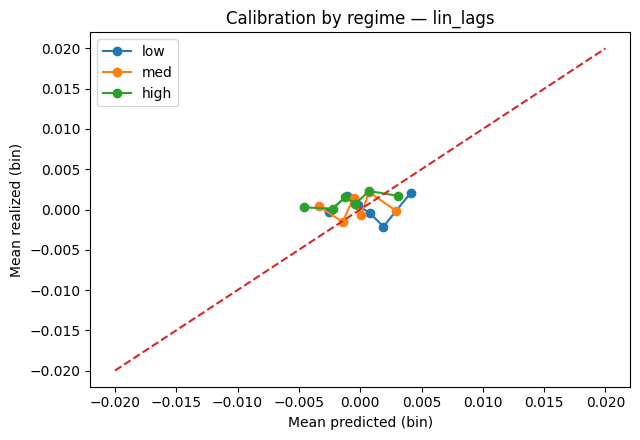

In [11]:
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, pathlib

def calibration_by_bins(df, pred_col, y_col="r_1d", n_bins=10):
    d = df.dropna(subset=[pred_col, y_col]).copy()
    d["bin"] = pd.qcut(d[pred_col], q=n_bins, duplicates="drop")  # qunatile cut, see below for more detail
    grp = d.groupby("bin").agg(
        mean_pred=(pred_col, "mean"),
        mean_true=(y_col, "mean"),
        count=(y_col, "size")
    ).reset_index()
    return grp

# Overall calibration (lin_lags) on validation slice
cal_overall = calibration_by_bins(val.dropna(subset=["yhat_lin"]), "yhat_lin", "r_1d", n_bins=10)

plt.figure(figsize=(5,4))
plt.plot(cal_overall["mean_pred"], cal_overall["mean_true"], marker="o")
lim = max(abs(cal_overall["mean_pred"]).max(), abs(cal_overall["mean_true"]).max())
plt.plot([-lim, lim], [-lim, lim], linestyle="--") # 45 degree line
plt.xlabel("Mean predicted (bin)"); plt.ylabel("Mean realized (bin)")
plt.title("Calibration (overall) — lin_lags")
plt.tight_layout()
plt.savefig("docs/figs/calibration_overall_lin.png", dpi=160)
"Saved docs/figs/calibration_overall_lin.png"

# By regime
plt.figure(figsize=(6.5,4.5))
for i, reg in enumerate(["low","med","high"], start=1):
    g = val[(val["regime"]==reg) & (val["yhat_lin"].notna())]
    if len(g) < 50:
        continue
    cal = calibration_by_bins(g, "yhat_lin", "r_1d", n_bins=6)
    plt.plot(cal["mean_pred"], cal["mean_true"], marker="o", label=reg)
lim = 0.02  # small returns
plt.plot([-lim, lim], [-lim, lim], linestyle="--")  #plot the 45 degree line
plt.xlabel("Mean predicted (bin)"); plt.ylabel("Mean realized (bin)")
plt.title("Calibration by regime — lin_lags")
plt.legend()
plt.tight_layout()
plt.savefig("docs/figs/calibration_by_regime_lin.png", dpi=160)
"Saved docs/figs/calibration_by_regime_lin.png"

# Quantile cut


```python
d["bin"] = pd.qcut(d[pred_col], q=n_bins, duplicates="drop")
```


###  `pd.qcut(...)`

`qcut` stands for **quantile cut** — it divides data into bins **so that each bin has (approximately) the same number of observations**.

It’s different from `pd.cut` (which uses **fixed numeric edges**).

**Syntax:**

```python
pd.qcut(x, q, labels=None, duplicates="raise")
```

* **`x`** – numeric array or Series
* **`q`** – number of quantiles or list of quantile boundaries

  * e.g. `q=4` → quartiles (25%, 50%, 75%, 100%)
  * or a list like `[0, 0.25, 0.5, 0.75, 1]`
* **`duplicates="drop"`** – if some quantile edges are identical (due to tied values), it silently drops those bins instead of raising an error

---

###  `q=n_bins`

If `n_bins = 5`, you’re dividing the column into **5 quantile bins**
→ each bin has about 20% of the data.

For instance, if `pred_col` has 1000 rows, each bin would roughly contain 200.

---

### 4. The result

The result of `pd.qcut(...)` is a **pandas Categorical** — each value in `d[pred_col]` is replaced with a bin label representing the interval it falls into.

Example:

```python
d["bin"] = pd.qcut(d["forecast"], q=4)
```

produces:

| forecast | bin            |
| -------- | -------------- |
| 0.02     | (-0.001, 0.05] |
| 0.04     | (-0.001, 0.05] |
| 0.10     | (0.05, 0.12]   |
| 0.15     | (0.12, 0.25]   |
| 0.30     | (0.25, 0.6]    |
| 0.60     | (0.25, 0.6]    |

So, each row gets a categorical label like `(-0.001, 0.05]`, meaning its value lies in that quantile range.

---

### Why use `duplicates="drop"`

Sometimes your column has many identical values or not enough distinct ones to form all bins.
In that case, some quantile cut points will be the same, and without this argument, pandas would raise an error:

```
ValueError: Bin edges must be unique
```

By adding `duplicates="drop"`, pandas automatically removes the redundant bin boundaries.

Example:

```python
pd.qcut([1,1,1,2,3,4], q=4, duplicates="drop")
```

→ produces fewer than 4 bins, but works.

-
###  Typical use

You often see this in model evaluation or calibration:

```python
# Evaluate prediction accuracy by score decile
d["bin"] = pd.qcut(d[pred_col], q=10, duplicates="drop")
d.groupby("bin")["r_1d"].mean()
```

That shows the **average actual return per score decile**, a common way to check **monotonicity** of model outputs.



In [12]:
pd.qcut([1,1,1,2,3,4], q=4, duplicates="drop")

[(0.999, 1.5], (0.999, 1.5], (0.999, 1.5], (1.5, 2.75], (2.75, 4.0], (2.75, 4.0]]
Categories (3, interval[float64, right]): [(0.999, 1.5] < (1.5, 2.75] < (2.75, 4.0]]

## Wrap‑up — key points to emphasize

-   **Regime thresholds must be set on TRAIN ONLY** each split to avoid leakage.
-   Report **by‑regime** metrics alongside overall metrics; show **macro** & **micro**.
-   Calibration plots (binned predicted vs. realized) quickly show **systematic bias**; compare regimes.

------------------------------------------------------------------------

## Homework (due before Session 19)

**Goal:** Produce a **full regime‑aware evaluation** across **all splits** for **naive** and **linear‑lags** models and include the figures in your Quarto report.

### A. Script: `scripts/regime_eval.py` — run across all splits

In [13]:
# save to scripts/regime_eval.py
#!/usr/bin/env python
from __future__ import annotations
import argparse, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def make_splits(dates, train_min=252, val_size=63, step=63, embargo=5):
    u = np.array(sorted(pd.to_datetime(pd.Series(dates).unique())))
    splits=[]; i=train_min-1; n=len(u)
    while True:
        if i>=n: break
        a,b = u[0], u[i]; vs=i+embargo+1; ve=vs+val_size-1
        if ve>=n: break
        splits.append((a,b,u[vs],u[ve])); i+=step
    return splits

def regime_thresholds(train_df, vol_col="roll_std_20", q_low=0.33, q_high=0.66):
    v = train_df[vol_col].dropna().to_numpy()
    if len(v) < 100:
        q_low, q_high = 0.4, 0.8
    return float(np.quantile(v, q_low)), float(np.quantile(v, q_high))

def label_regime(df, vol_col, lo, hi):
    out = df.copy()
    vc = out[vol_col]
    reg = pd.Series(pd.Categorical(["unknown"]*len(out), categories=["low","med","high","unknown"]), index=out.index)
    reg[(vc.notna()) & (vc <= lo)] = "low"
    reg[(vc.notna()) & (vc > lo) & (vc < hi)] = "med"
    reg[(vc.notna()) & (vc >= hi)] = "high"
    out["regime"] = reg.astype("category")
    return out

def add_naive(df):
    out = df.copy()
    out["yhat_naive"] = out["log_return"]
    return out

def fit_lin(tr, va, xcols):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    preds=[]
    for tkr, trk in tr.groupby("ticker"):
        vak = va[va["ticker"]==tkr]
        if len(trk)==0 or len(vak)==0: continue
        Xtr = trk.dropna(subset=xcols);
        pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
        pipe.fit(Xtr[xcols].values, Xtr["r_1d"].values)
        yhat = pipe.predict(vak[xcols].fillna(0).values)
        out = vak[["date","ticker","r_1d","log_return","regime"]].copy()
        out["yhat_lin"] = yhat
        preds.append(out)
    return pd.concat(preds, ignore_index=True) if preds else pd.DataFrame()

def mae(y, yhat): y=np.asarray(y); yhat=np.asarray(yhat); return float(np.mean(np.abs(y-yhat)))
def smape(y,yhat,eps=1e-8):
    y=np.asarray(y); yhat=np.asarray(yhat); return float(np.mean(2*np.abs(y-yhat)/(np.abs(y)+np.abs(yhat)+eps)))
def mase(y_true, y_pred, y_train_true, y_train_naive):
    return float(mae(y_true, y_pred)/(mae(y_train_true, y_train_naive)+1e-12))

def per_regime_metrics(val_df, train_df, pred_col):
    rows = []

    # Pre-group training by ticker once (faster)
    train_by_ticker = {
        tkr: g.dropna(subset=["r_1d"])
        for tkr, g in train_df.groupby("ticker")
    }

    for reg, g in val_df.groupby("regime"):
        if reg == "unknown" or len(g) == 0:
            continue

        per_t = []
        for tkr, gv in g.groupby("ticker"):
            gt = train_by_ticker.get(tkr)
            if gt is None or gt.empty:
                continue

            # Align & drop NaNs in y / yhat
            y = gv["r_1d"]
            yhat = gv[pred_col]
            mask = y.notna() & yhat.notna()
            if not mask.any():
                continue

            y = y[mask]
            yhat = yhat[mask]

            # If mase needs clean scaling inputs, align/drop there too
            m = {
                "ticker": tkr,
                "n": int(mask.sum()),
                "mae": float(mae(y, yhat)),
                "smape": float(smape(y, yhat)),
                "mase": float(mase(y, yhat, gt["r_1d"], gt["log_return"])),
                "regime": reg,
            }
            per_t.append(m) # per_t is a list of dict of the same structure

        per_t = pd.DataFrame(per_t) # convert a list of dict into a dataframe
        if per_t.empty:
            continue

        macro = per_t[["mae", "smape", "mase"]].mean().to_dict()

        w = per_t["n"].to_numpy()
        wsum = w.sum()
        if wsum == 0:
            # fall back to macro if no weights
            micro = {
                "micro_mae": float(per_t["mae"].mean()),
                "micro_smape": float(per_t["smape"].mean()),
                "micro_mase": float(per_t["mase"].mean()),
            }
        else:
            micro = {
                "micro_mae": float(np.average(per_t["mae"], weights=w)),
                "micro_smape": float(np.average(per_t["smape"], weights=w)),
                "micro_mase": float(np.average(per_t["mase"], weights=w)),
            }

        rows.append({ # build a new dict by adding new fields.
            "regime": reg,
            **{f"macro_{k}": float(v) for k, v in macro.items()},
            **micro # unpacking an existing dict into key-value pairs inline
        })

    return pd.DataFrame(rows)

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--features", default="data/processed/features_v1.parquet")
    ap.add_argument("--train-min", type=int, default=80)
    ap.add_argument("--val-size", type=int, default=21)
    ap.add_argument("--step", type=int, default=21)
    ap.add_argument("--embargo", type=int, default=5)
    ap.add_argument("--vol-col", default="roll_std_20")
    ap.add_argument("--xcols", nargs="+", default=["lag1","lag2","lag3"])
    ap.add_argument("--out-summary", default="reports/regime_summary.csv")
    # args = ap.parse_args(). # not working in Colab
    args, unknown = ap.parse_known_args() # fix
    print("Parsed args:", args)

    df = pd.read_parquet(args.features).sort_values(["ticker","date"]).reset_index(drop=True)
    # Ensure vol col exists
    if args.vol_col not in df.columns:
        df[args.vol_col] = df.groupby("ticker")["log_return"].rolling(20, min_periods=20).std().reset_index(level=0, drop=True)

    # Build lags if missing
    for k in [1,2,3]:
        col = f"lag{k}"
        if col not in df.columns:
            df[col] = df.groupby("ticker")["log_return"].shift(k)

    splits = make_splits(df["date"], args.train_min, args.val_size, args.step, args.embargo)
    Path("reports").mkdir(parents=True, exist_ok=True)
    thresh_rec = {}

    rows=[]
    for sid,(a,b,c,d) in enumerate(splits, start=1):
        tr = df[(df["date"]>=a)&(df["date"]<=b)]
        va = df[(df["date"]>=c)&(df["date"]<=d)]
        lo, hi = regime_thresholds(tr, args.vol_col)
        thresh_rec[sid] = {"lo":lo, "hi":hi, "train_range":f"{a.date()}→{b.date()}"}
        trL = label_regime(tr, args.vol_col, lo, hi)
        vaL = label_regime(va, args.vol_col, lo, hi)

        # predictions
        trN, vaN = add_naive(trL), add_naive(vaL)
        val_lin = fit_lin(trN, vaN, args.xcols)
        vaN = vaN.merge(val_lin[["date","ticker","yhat_lin"]], on=["date","ticker"], how="left")

        # metrics
        m_naive = per_regime_metrics(vaN, trN, "yhat_naive").assign(split=sid, model="naive") # .assign(): add two columns: split, model. See below for more
        m_lin   = per_regime_metrics(vaN.dropna(subset=["yhat_lin"]), trN, "yhat_lin").assign(split=sid, model="lin_lags")

        out = pd.concat([m_naive, m_lin], ignore_index=True)
        out.to_csv(f"reports/regime_metrics_split{sid}.csv", index=False)
        rows.append(out)

    pd.concat(rows, ignore_index=True).to_csv(args.out_summary, index=False)
    Path("reports/regime_thresholds.json").write_text(json.dumps(thresh_rec, indent=2))
    print("Wrote", args.out_summary, "and per-split CSVs; thresholds saved to reports/regime_thresholds.json")

if __name__ == "__main__":
    main()

Parsed args: Namespace(features='data/processed/features_v1.parquet', train_min=80, val_size=21, step=21, embargo=5, vol_col='roll_std_20', xcols=['lag1', 'lag2', 'lag3'], out_summary='reports/regime_summary.csv')
Wrote reports/regime_summary.csv and per-split CSVs; thresholds saved to reports/regime_thresholds.json


##  What `.assign()` Does

`DataFrame.assign()` returns a **new DataFrame** with **added or modified columns**, without changing the original (unless you reassign it).

Syntax:

```python
df.assign(new_col1=value_or_function, new_col2=value_or_function)
```

Each “value_or_function” can be:

* a constant (e.g. `"train"`)
* a Series or array (e.g. `df["x"] * 2`)
* a function that takes the DataFrame as input (`lambda df: ...`)

---

##  Example 1: Adding constant columns

```python
import pandas as pd

df = pd.DataFrame({
    "ticker": ["AAPL", "MSFT", "GOOG"],
    "price": [175, 330, 2900]
})

df2 = df.assign(split="val1", model="naive")

print(df2)
```

**Output:**

```
  ticker  price  split  model
0   AAPL    175   val1  naive
1   MSFT    330   val1  naive
2   GOOG   2900   val1  naive
```

→ `.assign()` adds two new columns with constant values.

---

##  Example 2: Adding computed columns

```python
df2 = df.assign(price_usd=df["price"], price_eur=df["price"] * 0.93)
print(df2)
```

**Output:**

```
  ticker  price  price_usd  price_eur
0   AAPL    175        175     162.75
1   MSFT    330        330     306.90
2   GOOG   2900       2900    2697.00
```

---

##  Example 3: Using functions (lambdas)

Each value can be a callable that takes the **whole DataFrame**:

```python
df2 = df.assign(
    log_price=lambda d: np.log(d["price"]),
    centered=lambda d: d["price"] - d["price"].mean()
)
```

**Output:**

```
  ticker  price  log_price  centered
0   AAPL    175   5.164786 -1331.67
1   MSFT    330   5.799093 -1176.67
2   GOOG   2900   7.974463  1393.33
```

---

##  Example 4: Overwriting existing columns

```python
df2 = df.assign(price=df["price"] * 1.1)
```

This **modifies** the `price` column but does **not** change `df` itself (unless you assign back: `df = df.assign(...)`).

---

##  Example 5: Chaining `.assign()`

You can chain operations:

```python
df2 = (
    df
    .assign(price_log=lambda d: np.log(d["price"]))
    .assign(split="val2", model="linear")
)
```

This is common in clean pipelines, e.g.:

```python
metrics = (
    per_regime_metrics(val_df, train_df, "yhat_linear")
    .assign(split="val1", model="linear")
)
```

---

##  Example 6: Combining with grouping or metrics

Say you have:

```python
metrics = pd.DataFrame({
    "ticker": ["AAPL", "MSFT"],
    "mae": [0.012, 0.015],
    "smape": [8.2, 9.1]
})
```

You can add tags:

```python
m_tagged = metrics.assign(split="fold_1", model="naive")
```

→ Result:

```
  ticker    mae  smape   split  model
0   AAPL  0.012    8.2  fold_1  naive
1   MSFT  0.015    9.1  fold_1  naive
```

This pattern is very common in your kind of code — for collecting metrics across models and validation folds.

---

###  Summary Table

| Type             | Example                                           | Result                   |
| ---------------- | ------------------------------------------------- | ------------------------ |
| Add constant     | `.assign(model="naive")`                          | Adds a column            |
| Add computed     | `.assign(log_price=lambda d: np.log(d["price"]))` | Adds computed column     |
| Modify existing  | `.assign(price=df["price"]*1.1)`                  | Updates column           |
| Multiple at once | `.assign(split="v1", model="linear")`             | Adds 2 columns           |
| Chainable        | `.assign(...).assign(...)`                        | Supports method chaining |

---



In [14]:
%%bash
chmod +x scripts/regime_eval.py
python scripts/regime_eval.py

Parsed args: Namespace(features='data/processed/features_v1.parquet', train_min=80, val_size=21, step=21, embargo=5, vol_col='roll_std_20', xcols=['lag1', 'lag2', 'lag3'], out_summary='reports/regime_summary.csv')
Wrote reports/regime_summary.csv and per-split CSVs; thresholds saved to reports/regime_thresholds.json


### B. Plot summary figures for your report

'Saved docs/figs/regime_micro_mae.png'

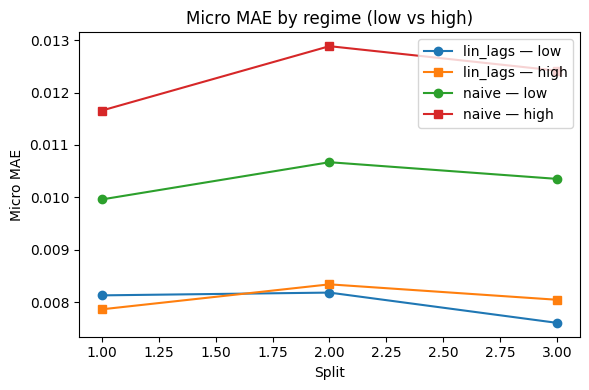

In [15]:
import pandas as pd, matplotlib.pyplot as plt, pathlib
pathlib.Path("docs/figs").mkdir(parents=True, exist_ok=True)

df = pd.read_csv("reports/regime_summary.csv")
# Micro MAE by regime per model
pivot = df.pivot_table(index=["split","regime"], columns="model", values="micro_mae")
plt.figure(figsize=(6,4))
for model in pivot.columns:
    plt.plot(pivot.xs("low", level="regime").index, pivot.xs("low", level="regime")[model], marker="o", label=f"{model} — low") # see below for more
    plt.plot(pivot.xs("high", level="regime").index, pivot.xs("high", level="regime")[model], marker="s", label=f"{model} — high")
plt.xlabel("Split"); plt.ylabel("Micro MAE")
plt.title("Micro MAE by regime (low vs high)")
plt.legend(); plt.tight_layout()
plt.savefig("docs/figs/regime_micro_mae.png", dpi=160)
"Saved docs/figs/regime_micro_mae.png"

In [16]:
df.head()

,regime,macro_mae,macro_smape,macro_mase,micro_mae,micro_smape,micro_mase,split,model
0,low,0.010896,1.401762,1.023209,0.009961,1.470442,0.948458,1,naive
1,med,0.012401,1.575014,1.149930,0.011820,1.547136,1.110862,1,naive
2,high,0.011426,1.464757,1.055282,0.011656,1.417321,1.066599,1,naive
3,low,0.010333,1.726408,0.969139,0.008131,1.629521,0.771618,1,lin_lags
4,med,0.008137,1.664620,0.757888,0.007879,1.680100,0.741442,1,lin_lags


In [17]:
pivot.head()

model         lin_lags     naive
split regime                    
1     high    0.007865  0.011656
      low     0.008131  0.009961
      med     0.007879  0.011820
2     high    0.008341  0.012885
      low     0.008184  0.010671


```python
plt.plot(
    pivot.xs("low", level="regime").index,
    pivot.xs("low", level="regime")[model],
    marker="o",
    label=f"{model} — low"
)
```

---


### (a) The pivot table

```python
pivot = df.pivot_table(index=["split","regime"], columns="model", values="micro_mae")
```

This produces a **multi-index DataFrame** where:

* The **row index** has two levels: `"split"` and `"regime"`
* The **columns** correspond to different model names
* The **values** are the metric `micro_mae`

Example (conceptual):

| split | regime | naive | linear | lstm  |
| :---- | :----- | :---- | :----- | :---- |
| val1  | low    | 0.012 | 0.011  | 0.010 |
| val1  | high   | 0.018 | 0.016  | 0.015 |
| val2  | low    | 0.014 | 0.013  | 0.012 |
| val2  | high   | 0.019 | 0.017  | 0.016 |

Here, the index is a **MultiIndex** with levels:

```
split → e.g. ["val1", "val2"]
regime → ["low", "high"]
```

---

## 2. What `.xs("low", level="regime")` does

`xs()` stands for **cross section** — it selects rows where a certain **index level** equals a given value.

```python
pivot.xs("low", level="regime")
```

means:

> “From the MultiIndex DataFrame `pivot`, take only those rows where the `regime` level is `"low"`.”

The result is a **smaller DataFrame** indexed only by `split` (because we fixed `regime`):

```
         naive  linear   lstm
split
val1     0.012  0.011  0.010
val2     0.014  0.013  0.012
```

---

##  3. `pivot.xs("low", level="regime").index`

That’s the **x-axis data** — the index of the subset (i.e. the `"split"` values).
→ `["val1", "val2"]` or numerical equivalents if `split` was numeric.

So this provides the x-coordinate sequence.

---

##  4. `pivot.xs("low", level="regime")[model]`

That’s the **y-axis data** for one specific model column.

If `model="naive"`, it yields a Series:

```
split
val1    0.012
val2    0.014
Name: naive, dtype: float64
```

That’s what will be plotted on the y-axis.



### C. Add to Quarto report (I did not verify this)

In `reports/eda.qmd` (or a new `reports/regime.qmd`), include:

````markdown
\#\# Regime‑aware Results

```{python}
import pandas as pd
df = pd.read_csv("reports/regime_summary.csv")
df.sort_values(["split","model","regime"]).head(12)

![](../docs/figs/regime_micro_mae.png)

![](../docs/figs/calibration_overall_lin.png)

![](../docs/figs/calibration_by_regime_lin.png)

````

Render:
quarto render reports/eda.qmd


### D. Quick test to protect **train‑only** thresholds


In [18]:
# save to tests/test_regime_thresholds.py
import json, pandas as pd

def test_thresholds_exist_and_train_range():
    data = json.load(open("reports/regime_thresholds.json"))
    assert len(data) >= 1
    # basic sanity: low < high
    for sid, rec in data.items():
        assert float(rec["lo"]) < float(rec["hi"])
        assert "→" in rec["train_range"]


In [19]:
%%bash
pytest -q -k regime_thresholds

.                                                                        [100%]
